In [1]:
#Let there be np.light
import numpy as np
import pylab as plt
import pickle as pkl
import csv
# import scipy.optimize, scipy.interpolate
import scipy.optimize as spop
import time

#Constructing fitter
def designfit(x_array,y_array, A):
    N = len(design) # number of variational parameters
    
    #Solving for fit parameters. 
    return np.linalg.solve( np.matmul(A.T,A) , np.matmul(A.T,y_array) )

def fit(data, design, weights):
    N = len(design) # number of variational parameters
    sqrt_weights = np.sqrt(weights)
    
    # Incorporating weights, if given
    for i in range(len(design)): # absorbing weights in the design matrix
        design[i] = design[i]*sqrt_weights[i]
    
    data = data*sqrt_weights # absorbing into the data vector 

    # Solving for fit parameters. 
    return np.linalg.lstsq(design, data, rcond=None)[0]


# Defining functions

In [2]:
def minimize_pics_lstsq(data, P, Q, init_guess, n_it, len_y):
    'P is the design function in x, and \
     Q is the design function in y.'

    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    z = data.flatten()
    
    # Initializing arrays and values
    y = np.zeros(len(init_guess[:len_y]))
    x = np.zeros(len(init_guess[len_y:]))
    y[:] = init_guess[:len_y]
    x[:] = init_guess[len_y:]
    weight = np.ones_like(data.flatten())
    
    counter = 0
    lsq = 1
    
    while counter < n_it or counter == 1:        
        counter += 1
        sqrt_weight = np.sqrt(weight)
        
        # Solving f(x) parameters
        bQ = np.matmul(y,Q.T)
        M = np.copy(P)
        for i in range(len(M)):
            M[i] = (bQ*sqrt_weight)[i]*M[i]
        x[:] = np.linalg.lstsq(M,z*sqrt_weight,rcond=None)[0][:]
        
        # Solving g(y) parameters
        aP = np.matmul(x,P.T)
        M = np.copy(Q)
        for i in range(len(M)):
            M[i] = (aP*sqrt_weight)[i]*M[i]
        y[:] = np.linalg.lstsq(M,z*sqrt_weight,rcond=None)[0][:]
        
        # Updating squared error matrix; removing zeroes
        y_hat = np.matmul(design_y,y)
        x_hat = np.matmul(design_x,x)
        model = y_hat*x_hat
        weight = np.abs(z - model.flatten())
        weight = 1/np.clip(weight, 0.000000000001, None)
        
        plt.imshow(model.reshape(np.shape(data)), origin='lower')
        plt.show()
        
        print(counter)

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    
    residual = z - y_hat*x_hat    
    plt.imshow(residual.reshape(np.shape(data)), origin='lower')
    plt.colorbar()
    plt.show()
    
    return y,x  

In [3]:
def minimize_pics_lstsq2(data, P, Q, init_guess, n_it, len_y):
    'P is the design function in x, and \
     Q is the design function in y.'

    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    z = data.flatten()
    
    # Initializing arrays and values
    y = np.zeros(len(init_guess[:len_y]))
    x = np.zeros(len(init_guess[len_y:]))
    y[:] = init_guess[:len_y]
    x[:] = init_guess[len_y:]
    weight = np.ones_like(data.flatten())
    
    counter = 0
    lsq = 1
    
    while counter < n_it or counter == 1:        
        counter += 1
        sqrt_weight = np.sqrt(weight)
        
        # Solving f(x) parameters
        bQ = np.matmul(y,Q.T)
        M = np.copy(P)
        for i in range(len(M)):
            M[i] = (bQ*sqrt_weight)[i]*M[i]
        x[:] = np.linalg.lstsq(M,z*sqrt_weight,rcond=None)[0][:]
        
        # Solving g(y) parameters
        aP = np.matmul(x,P.T)
        M = np.copy(Q)
        for i in range(len(M)):
            M[i] = (aP*sqrt_weight)[i]*M[i]
        y[:] = np.linalg.lstsq(M,z*sqrt_weight,rcond=None)[0][:]
        
        # Updating squared error matrix; removing zeroes
        y_hat = np.matmul(design_y,y)
        x_hat = np.matmul(design_x,x)
        model = y_hat*x_hat
        weight = np.abs(z - model.flatten())
        weight = 1/np.clip(weight, 0.000000000001, None)
        
        plt.imshow(model.reshape(np.shape(data)), origin='lower')
        plt.show()
        
        print(counter)

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

## Point-to-point minimization

In [4]:
def remove_zeros(array):
    array = np.array(array).astype(float)
    shape = np.shape(array)
    flattened = array.flatten()
    
    flattened[np.argwhere(flattened == 0)] = np.inf
    flattened[np.argwhere(flattened == np.inf)] = 0.0001
    
    return flattened.reshape(shape)

def minimize_ptp(data, init_guess, tol, n_it):
    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    len_y = len(data) 
    
    # Initializing arrays and values
    y = np.empty(len(init_guess[:len_y]))
    x = np.empty(len(init_guess[len_y:]))
    y_prev = np.empty(len(init_guess[:len_y]))
    x_prev = np.empty(len(init_guess[len_y:]))
    y_prev[:] = init_guess[:len_y]
    x_prev[:] = init_guess[len_y:]
    sqerror = np.ones_like(data)
    
    counter = 0
    lsq = 1
    
    while ( lsq > tol and counter < n_it ) or counter == 1:
        counter += 1

        # Updating parameters
        for i in range(len(x)):
            x[i] = np.matmul(y_prev,data/sqerror)[i]/np.matmul(y_prev**2,1/sqerror)[i]
        for i in range(len(y)):
            y[i] = np.matmul(data/sqerror,x_prev)[i]/np.matmul(1/sqerror,x_prev**2)[i]
        
        # Updating previous guess
        
        y_prev[:] = y[:]
        x_prev[:] = x[:]
        
        # Updating squared error matrix; removing zeroes
        sqerror = np.abs((data - np.outer(y,x)))
        sqerror = np.clip(sqerror, 0.000000000001, None)

        lsq = np.sum(sqerror)/N**2
        
#         print(f'{lsq}/{tol}, {counter}')

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

## Fourier design constructor

In [5]:
def fourier_design(x_array, n_freq):
    'In (column) list, cosines followed sines.'
#     assert 2*n_freq < len(x_array)
    
    L = np.max(x_array) - np.min(x_array)
    k0 = 2*np.pi/L
    
    output_cos = [np.cos(k0*i*x_array) for i in range(n_freq)]
    output_sin = [np.sin(k0*i*x_array) for i in range(1,n_freq)]
    
    return np.concatenate((output_cos, output_sin)).T

# Testing Fourier design matrix

# index = 9
# n_freqs = 10
# test1 = np.column_stack((xxs_flat,fourier_design(xxs_flat,n_freqs)[:,index]))
# test1 = test1[np.argsort(test1[:,0])]
# test2 = np.column_stack((xxs_flat,fourier_design(xxs_flat,n_freqs)[:,n_freqs+index-1]))
# test2 = test2[np.argsort(test2[:,0])]
# plt.plot(test1[:,0], test1[:,1],)
# plt.plot(test2[:,0], test2[:,1])

# 1-D function

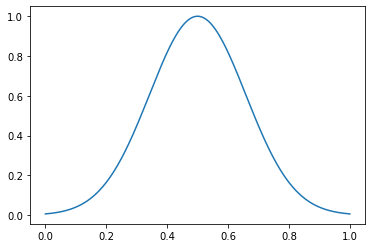

In [11]:
def trial(x):
    return np.exp(-(x-0.5)**2/0.05)
#     return np.sin(3*x*np.pi)
#     return np.ones(len(x))

xs = np.linspace(0,1,500)
data = trial(xs)
plt.plot(xs, data)

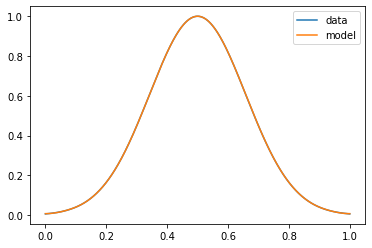

In [12]:
design = fourier_design(xs,10)
parameters = fit(data,design,np.ones_like(xs))
plt.plot(xs, data, label='data')
plt.plot(xs, np.matmul(design, parameters), label='model')
plt.legend()
plt.show()

# Outer product; Gaussian x 1

## Sample data

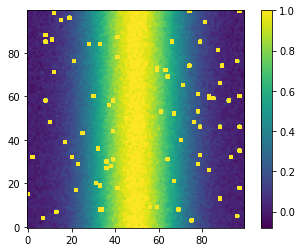

In [940]:
xs = np.linspace(0,1,100)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
#    return 1*(np.sin(yy))**2*np.exp(-(xx-0.5)**2/0.05)
    return np.exp(-(xx-0.5)**2/0.05)

data_clean = f(ys,xs)
cosmic_rays = 0.5*(1 + np.sign( (1/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 1000*cosmic_rays

plt.imshow(data_sim, origin='lower', vmax=1)
plt.colorbar()
plt.show()

## Modelling sample data (iterative lin. alg.)

In [ ]:
# Constructing grid points
xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

# Uncomment for Fourier fit
n_freq_x = 5
n_freq_y = 5
x_len = 2*n_freq_x - 1
y_len = 2*n_freq_y - 1
design_x = fourier_design(xxs_flat,n_freq_x)
design_y = fourier_design(yys_flat,n_freq_y)

initial_guess = np.zeros(y_len+x_len)
initial_guess[0] = 1
initial_guess[y_len] = 1

# Uncomment for polynomial fit
# x_len = 11
# y_len = 11
# design_x = np.array([xxs_flat**i for i in range(x_len)]).T
# design_y = np.array([yys_flat**i for i in range(y_len)]).T

# initial_guess = np.ones(y_len+x_len)

guess = minimize_pics_lstsq(data_sim, design_x, design_y, initial_guess, 10, y_len)

Function in x:


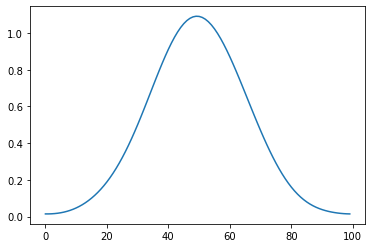

Function in y:


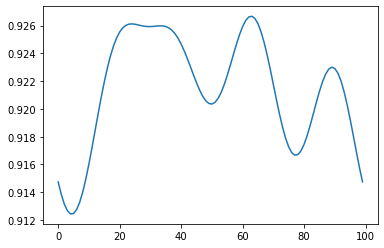

2-D plot


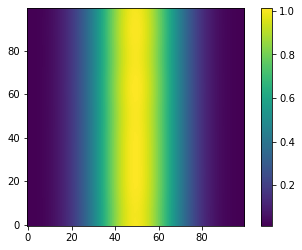

In [779]:
# Uncomment for Fourier fit
design_y_test = fourier_design(ys, n_freq_y)
design_x_test = fourier_design(xs, n_freq_x)

# Uncomment for polynomial fit
# design_y_test = np.array([ys**i for i in range(y_len)]).T
# design_x_test = np.array([xs**i for i in range(x_len)]).T

print('Function in x:')
plt.plot(np.matmul(design_x_test,guess[1]))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,guess[0]))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,guess[0])
x_hat = np.matmul(design_x_test,guess[1])

plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()

## Using scipy.optimize

In [ ]:
y_len = 4

design_y = np.array([yys_flat**i for i in range(y_len)]).T
design_x = np.array([xxs_flat**i for i in range(11)]).T

design_y_test = np.array([ys**i for i in range(y_len)]).T
design_x_test = np.array([xs**i for i in range(11)]).T

def loss(parameters, data, design_y, design_x, len_y):
    b = parameters[:len_y]
    a = parameters[len_y:]
    y_hat = np.matmul(design_y,b)
    x_hat = np.matmul(design_x,a)
    return np.sum((data - y_hat*x_hat)**2)

initial_guess = np.ones(11+y_len)

start_time = time.time()
guess2 = spop.minimize(loss,initial_guess, (data_sim.flatten(),design_y,design_x,y_len))
print(time.time()-start_time)

In [ ]:
# Model data

b_para = guess2.x[:y_len]
a_para = guess2.x[y_len:]

print('Function in x:')
plt.plot(np.matmul(design_x_test,a_para))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,b_para))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,b_para)
x_hat = np.matmul(design_x_test,a_para)
plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()

# Outer product; Gaussian x Sine

## Sample data

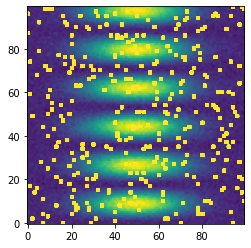

In [941]:
xs = np.linspace(0,1,100)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
    return 1*(np.sin(2*np.pi*yy/(2.5/7)))**2*np.exp(-(xx-0.5)**2/0.05)

data_clean = f(ys,xs)
cosmic_rays = 0.5*(1 + np.sign( (3/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim2 = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 1000*cosmic_rays

plt.imshow(data_sim2, origin='lower', vmax=1)
plt.show()

## Modelling data (iterative lin. alg.)

In [ ]:
# Constructing grid points
xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

# Uncomment for Fourier fit
n_freq_x = 50
n_freq_y = 50
x_len = 2*n_freq_x - 1
y_len = 2*n_freq_y - 1
design_x = fourier_design(xxs_flat,n_freq_x)
design_y = fourier_design(yys_flat,n_freq_y)

initial_guess = np.zeros(y_len+x_len)
initial_guess[0] = 1
initial_guess[y_len] = 1

# Uncomment for polynomial fit
# x_len = 11
# y_len = 35
# design_x = np.array([xxs_flat**i for i in range(x_len)]).T
# design_y = np.array([yys_flat**i for i in range(y_len)]).T

# initial_guess = np.ones(x_len + y_len)

guess = minimize_pics_lstsq(data_sim2, design_x, design_y, initial_guess, 20, y_len)

Function in x:


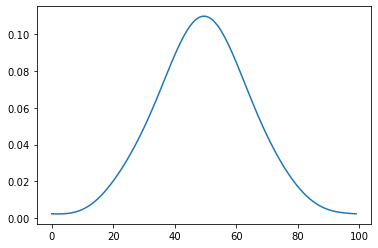

Function in y:


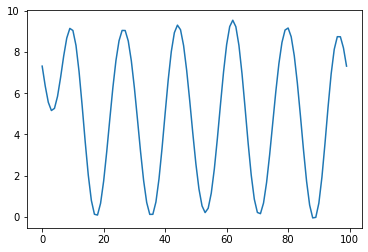

2-D plot


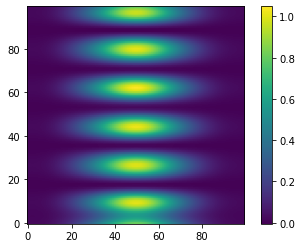

In [15]:
# Uncomment for Fourier fit
design_y_test = fourier_design(ys, n_freq_y)
design_x_test = fourier_design(xs, n_freq_x)

# Uncomment for polynomial fit
# design_y_test = np.array([ys**i for i in range(y_len)]).T
# design_x_test = np.array([xs**i for i in range(x_len)]).T

print('Function in x:')
plt.plot(np.matmul(design_x_test,guess[1]))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,guess[0]))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,guess[0])
x_hat = np.matmul(design_x_test,guess[1])

plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()

## Using scipy

In [ ]:
y_len = 35
x_len = 35

design_y = np.array([yys_flat**i for i in range(y_len)]).T
design_x = np.array([xxs_flat**i for i in range(x_len)]).T

design_y_test = np.array([ys**i for i in range(y_len)]).T
design_x_test = np.array([xs**i for i in range(x_len)]).T

def loss(parameters, data, design_y, design_x, len_y):
    b = parameters[:len_y]
    a = parameters[len_y:]
    y_hat = np.matmul(design_y,b)
    x_hat = np.matmul(design_x,a)
    return np.sum((data - y_hat*x_hat)**2)

initial_guess = np.ones(x_len+y_len)

start_time = time.time()
guess2 = spop.minimize(loss,initial_guess, (data_sim2.flatten(),design_y,design_x,y_len))
print(time.time()-start_time)

In [ ]:
# Model data

b_para = guess2.x[:y_len]
a_para = guess2.x[y_len:]

print('Function in x:')
plt.plot(np.matmul(design_x_test,a_para))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,b_para))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,b_para)
x_hat = np.matmul(design_x_test,a_para)
plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()

# APOGEE data

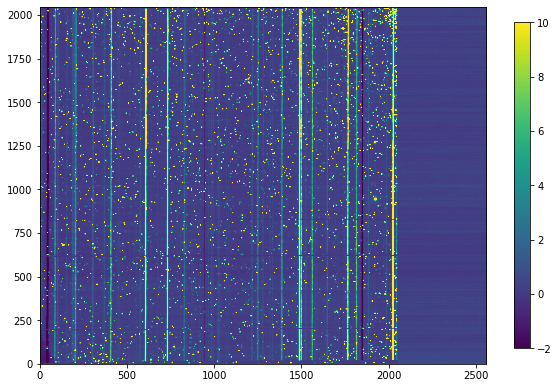

In [14]:
from astropy.io import fits

UNe_arc = fits.open("apR-a-27310005.fits")
data_actualx = UNe_arc[0].data

plt.figure(figsize=(10,10))
plt.imshow(data_actualx, vmin=-2, vmax=10, origin='lower')
plt.colorbar(shrink=0.6)
# plt.xlim(1000,1500)
# plt.ylim(650,750)
plt.show()

## Calibration lines list

In [15]:
xpix_chipnum1 = [11.83,
47.65,
90.78,
156.45,
192.24,
200.55,
208.09,
372.78,
410.50,
445.72,
455.44,
559.02,
577.59,
584.76,
679.23,
733.55,
792.02,
825.20,
830.95,
872.14,
881.42,
895.53,
916.37,
918.46,
940.72,
944.20,
953.51,
968.75,
978.77,
984.15,
994.98,
1017.72,
1026.76,
1041.71,
1065.25,
1069.92,
1082.56,
1161.79,
1216.08,
1246.64,
1250.39,
1278.98,
1318.63,
1333.56,
1387.15,
1469.38,
1472.84,
1487.79,
1497.39,
1523.94,
1560.58,
1576.59,
1590.31,
1600.67,
1617.12,
1646.11,
1659.44,
1709.20,
1729.53,
1764.00,
1806.14,
1813.60,
1816.92,
1830.73,
1846.41,
1863.79,
1880.54,
1894.51,
1921.42,
1977.04,
1985.48,
2022.38,
2032.44]

## Smaller section

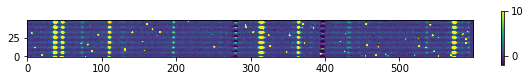

In [16]:
west_end = 1450
east_end = 2050
apogee_span = east_end - west_end

data_actual = UNe_arc[0].data[1650:1700,west_end:east_end]
plt.figure(figsize=(10,10))
plt.imshow(data_actual, vmin=-2, vmax=10, origin='lower')
plt.colorbar(shrink=0.1)
plt.show()

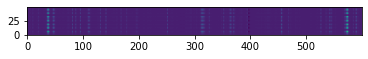

1


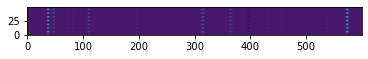

2


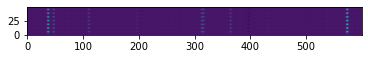

3


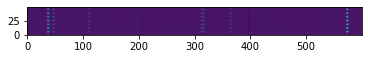

4


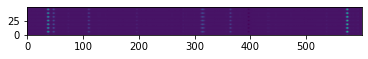

5
Time elapsed is 34.75396680831909. Iterations: 5.


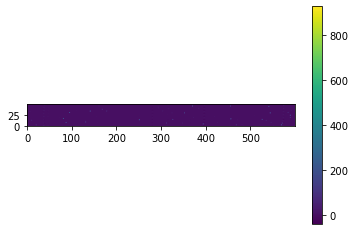

In [18]:
### Fourier ###

# Constructing grid points
xs = np.arange(len(data_actual[0]))
ys = np.arange(len(data_actual[:,0]))

xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

# Uncomment for Fourier fit
n_freq_x = int(len(data_actual[0])/2)
n_freq_y = int(len(data_actual)/2)
x_len = 2*n_freq_x - 1
y_len = 2*n_freq_y - 1
design_x = fourier_design(xxs_flat,n_freq_x)
design_y = fourier_design(yys_flat,n_freq_y)

initial_guess = np.zeros(y_len+x_len)
initial_guess[0] = 1
initial_guess[y_len] = 1

# initial_guess = np.ones(x_len + y_len)

guess = minimize_pics_lstsq(data_actual, design_x, design_y, initial_guess, 5, y_len)

In [19]:
### PTP minimization ###
initial_guess = np.ones(len(data_actual) + len(data_actual[0]))
y_model, x_model = minimize_ptp(data_actual, initial_guess, 0.0000000001, 5)

Time elapsed is 2.436393976211548. Iterations: 5.


Function in x:


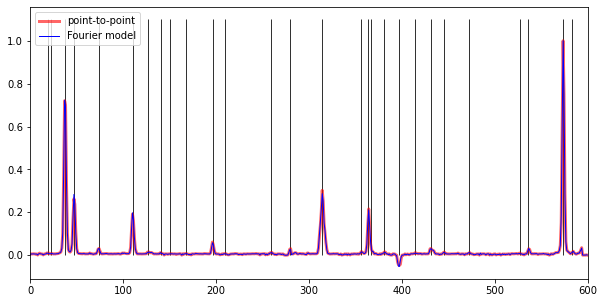

2-D plots:


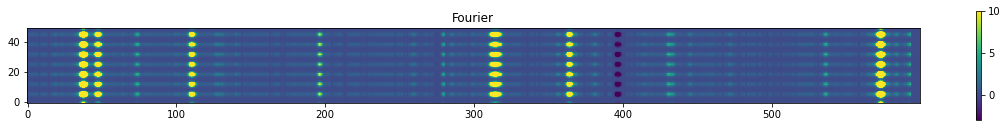

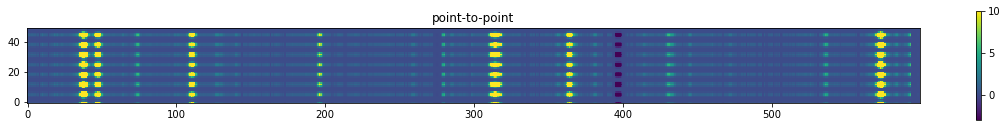

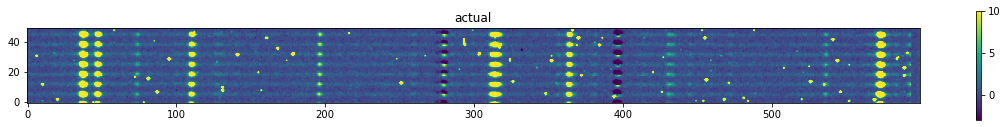

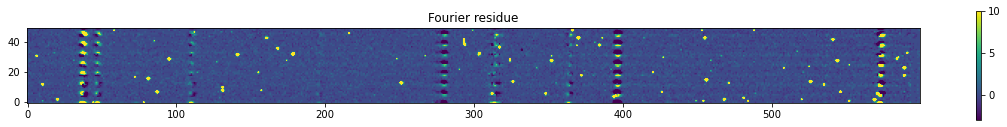

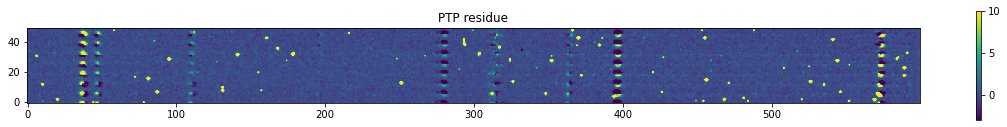

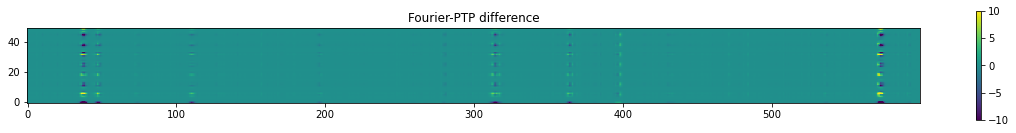

In [22]:
### Results ###

# Uncomment for Fourier fit
design_y_test = fourier_design(ys, n_freq_y)
design_x_test = fourier_design(xs, n_freq_x)

print('Function in x:')
f_x = np.matmul(design_x_test,guess[1])
plt.figure(figsize=(10,5))
plt.plot(x_model/np.max(x_model), label='point-to-point', color='red', lw=3, alpha=0.6)
plt.plot(f_x/np.max(f_x), label='Fourier model', lw=1, color='blue')
plt.vlines(np.array(xpix_chipnum1) - west_end, 0, 1.1, color='black', lw=0.8)
plt.xlim(0,apogee_span)
plt.legend()
plt.savefig('peaks.png')
plt.show()

# print('Function in y:')
# plt.plot(np.matmul(design_y_test,guess[0]))
# plt.show()

print('2-D plots:')
y_hat = np.matmul(design_y_test,guess[0])
x_hat = np.matmul(design_x_test,guess[1])

minv = -3
maxv = 10
minv_res = -3
maxv_res = 10
cbar_shrink = 0.1
sizefig = (20,20)

plt.figure(figsize=sizefig)
data_model_fourier = np.outer(y_hat,x_hat)
plt.imshow(data_model_fourier, vmin=minv, vmax=maxv, origin='lower')
plt.colorbar(shrink=cbar_shrink)
plt.title('Fourier')
plt.savefig('model_fourier.png')
plt.show()

plt.figure(figsize=sizefig)
data_model_ptp = np.outer(y_model,x_model)
plt.imshow(data_model_ptp, origin='lower', interpolation='none', vmin=minv, vmax=maxv)
plt.colorbar(shrink=cbar_shrink)
plt.title('point-to-point')
plt.savefig('model_ptp.png')
plt.show()

plt.figure(figsize=sizefig)
plt.imshow(data_actual, vmin=minv, vmax=maxv, origin='lower')
plt.colorbar(shrink=cbar_shrink)
plt.title('actual')
plt.savefig('actual.png')
plt.show()

plt.figure(figsize=sizefig)
plt.imshow(data_actual - data_model_fourier, vmax=maxv_res, vmin=minv_res, origin='lower')
plt.colorbar(shrink=cbar_shrink)
plt.title('Fourier residue')
plt.savefig('res_fourier.png')
plt.show()

plt.figure(figsize=sizefig)
plt.imshow(data_actual - data_model_ptp, vmax=maxv_res, vmin=minv_res, origin='lower')
plt.colorbar(shrink=cbar_shrink)
plt.title('PTP residue')
plt.savefig('res_ptp.png')
plt.show()

plt.figure(figsize=sizefig)
plt.imshow(data_model_fourier - data_model_ptp, vmax=10, vmin=-10, origin='lower')
plt.colorbar(shrink=cbar_shrink)
plt.title('Fourier-PTP difference')
plt.savefig('dif_fourier_ptp.png')
plt.show()

# Sketch

In [128]:
def fourier_design2(x_array, n_freq, L):
    'In (column) list, cosines followed sines.'
#     assert 2*n_freq < len(x_array)
    
    k0 = 2*np.pi/L
    
    output_cos = [np.cos(k0*i*x_array) for i in range(n_freq)]
    output_sin = [np.sin(k0*i*x_array) for i in range(1,n_freq)]
    
    return np.concatenate((output_cos, output_sin)).T


def fourier_design_module2(data, x_labels, y_labels, n_x, n_y, L_x, L_y):
    assert len(x_labels) == len(y_labels)
    assert len(x_labels) == len(data.flatten())

    fdesign_x = fourier_design2(x_labels,n_x, L_x)
    fdesign_y = fourier_design2(y_labels,n_y, L_y)
    
    return fdesign_x, fdesign_y

def shear_parameter_cofactor(design, parameters, orthocoord_vals, factors, length):
    assert len(design) == len(orthocoord_vals)
    assert len(design[0]) == len(parameters)

    n_freq = int((len(design[0]) + 1)/2)
    
    design_square = np.delete(design, 0, axis=1)

    ks_signed = np.array([2*np.pi*i/length for i in range(1,n_freq)] \
                  +[2*np.pi*i/length for i in range(1,n_freq_x)])
    signs = np.array([1 for i in range(1,n_freq)] \
                  +[-1 for i in range(1,n_freq)])
    ks_signed = ks_signed*signs

    para_square = np.delete(parameters, 0)
    para_square_rolled = np.roll(para_square, -(n_freq-1))

    ks_signed_times_pararolled = ks_signed*para_square_rolled

    output = np.matmul(design_square,ks_signed_times_pararolled)
    output = output*orthocoord_vals*factors
    
    return output

def minimize_test(data, n_x, n_y, init_guess, n_it, len_y, L_x, L_y):
    start_time = time.time()
    
    #XXXX Defining constants XXXX#
    N = len(data)*len(data[0])
    data_flat = data.flatten()
    ##############################
    
    
    #XXXX Initializing parameter and weight values XXXX#
    # Grid labels
    eta1_vals, eta2_vals = np.arange(len(data[0]))/len(data[0]), \
    np.arange(len(data[:,0]))/len(data[:,0])
    eta1_mesh, eta2_mesh = np.meshgrid(eta1_vals,eta2_vals)
    eta1_flat = eta1_mesh.flatten()
    eta2_flat = eta2_mesh.flatten() 
    eta1_flat_init = np.copy(eta1_flat)
    eta2_flat_init = np.copy(eta2_flat)
    
    # Fourier design matrices
    design_x, design_y = fourier_design_module2(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
    
    # Fourier coefficients
    y, x = np.zeros(len(init_guess[:len_y])), np.zeros(len(init_guess[len_y:]))
    y[:], x[:] = init_guess[:len_y], init_guess[len_y:]
    
    # Linear deformation parameters
    epsilon_matrix = lambda x : np.array([[1 - x[0], x[1]],[x[2], 1- x[3]]])
    deformation_matrix = epsilon_matrix([0,0,0,0])
    
    # Weights
    weights = np.ones_like(data_flat)
    ####################################################
    
    
    #XXXX Constructing handles for data model points XXXX#
    f = np.matmul(design_x,x) #function along the horizontal (x) evaluations
    g = np.matmul(design_y,y) #function along the vertical (y) evaluations
    ######################################################
    
    
    counter = 0
    while counter < n_it:        
        counter += 1
        print(f'Iteration {counter}:')
           
        ##### Solving f(x) parameters #####
        # Updating parameters
        design = np.array([design_x[i]*g[i] for i in range(len(design_x))])
        x[:] = fit(data_flat, design, weights)

        # Updating model-related values
        f = np.matmul(design_x,x)
        errors = np.abs(data_flat - np.matmul(design,x))
        weights = 1/np.clip(errors, 0.000000000001, None)
        ###################################


        ##### Solving g(y) parameters #####
        # Updating parameters
        design = np.array([design_y[i]*f[i] for i in range(len(design_y))])
        y[:] = fit(data_flat, design, weights)

        # Updating model-related values
        g = np.matmul(design_y,y)
        errors = np.abs(data_flat - np.matmul(design,y))
        weights = 1/np.clip(errors, 0.000000000001, None)
        ###################################
            
        sub_model = np.empty_like(data_flat)    
        sub_model[:] = (f*g)[:]
        
        epsilon_xy = 0
        
        for i in range(10):
            
            ##### Solving shear parameter along x #####           
            f1_terms = shear_parameter_cofactor(design_x, x, eta2_flat, g, 1)
            residual = data_flat - f*g
            epsilon_xy += np.dot(residual*weights, f1_terms)/np.dot(f1_terms*weights, f1_terms)
            deformation_matrix = epsilon_matrix([0,epsilon_xy,0,0])
            ###########################################

            ##### Deforming grid #####
            etas_stacked = np.vstack((eta1_flat_init,eta2_flat_init)) 
            etas_stacked = np.matmul(deformation_matrix, etas_stacked)    
            eta1_flat[:] = etas_stacked[0,:]
            eta2_flat[:] = etas_stacked[1,:]
            ##########################

            ##### Updating Fourier design matrices #####
            design_x, design_y = fourier_design_module2(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
            f, g = np.matmul(design_x,x), np.matmul(design_y,y)
            ############################################
        
        
        ##### Plotting intermediate models #####
        model = f*g
        residue = data_flat - model
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        im1 = ax1.imshow(model.reshape(np.shape(data)), origin='lower')
        im2 = ax2.imshow(residue.reshape(np.shape(data)), origin='lower')
        ax1.set_title('model')
        ax2.set_title('residue')
        fig.colorbar(im1, ax=ax1, shrink=0.6)
        fig.colorbar(im2, ax=ax2, shrink=0.6)
        fig.tight_layout()
        plt.show()
        ##########################
    
    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    
    
    return y, x, epsilon_xy

## Simulated data with tilt

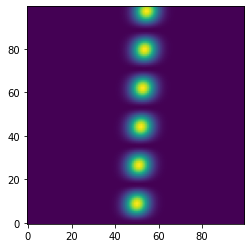

In [129]:
xs = np.linspace(0,1,100)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
    return 1*(np.sin(2*np.pi*(yy)/(2.5/7)))**2*np.exp(-(xx - yy*0.05 -0.5)**2/0.003)
#     return np.exp(-(xx + yy*(-0.08) - 0.5)**2/0.05)

data_clean = f(ys,xs)
cosmic_rays = 0.5*(1 + np.sign( (3/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim = data_clean + 0.05*0*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 0*1000*cosmic_rays

plt.imshow(data_sim, origin='lower', vmax=1)
plt.show()

Iteration 1:


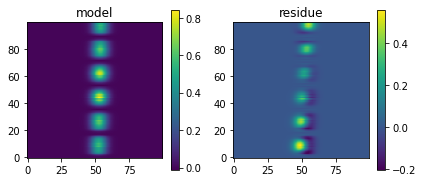

Iteration 2:


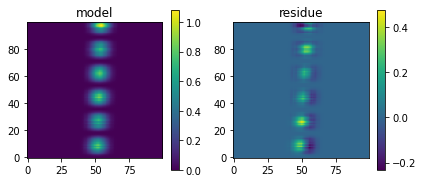

Iteration 3:


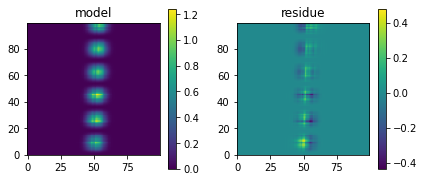

Iteration 4:


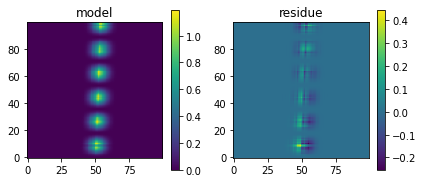

Iteration 5:


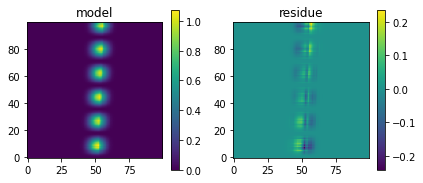

Iteration 6:


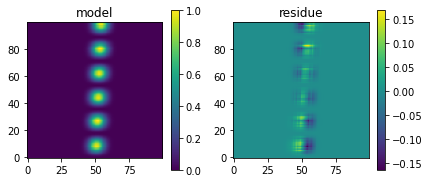

Iteration 7:


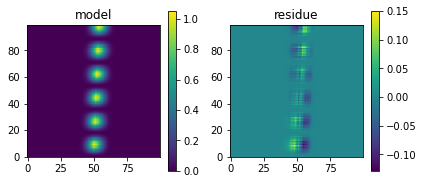

Iteration 8:


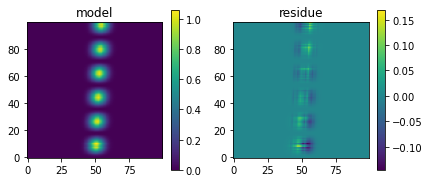

Iteration 9:


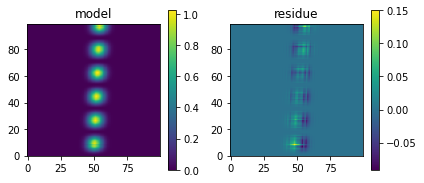

Iteration 10:


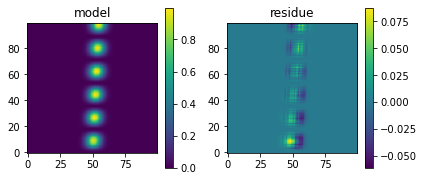

Iteration 11:


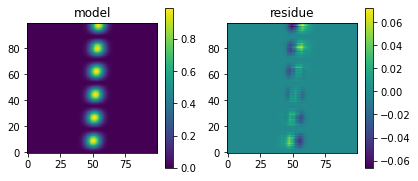

Iteration 12:


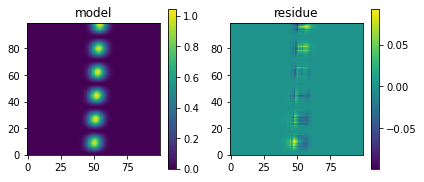

Iteration 13:


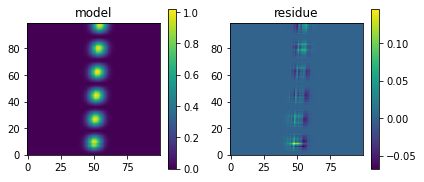

Iteration 14:


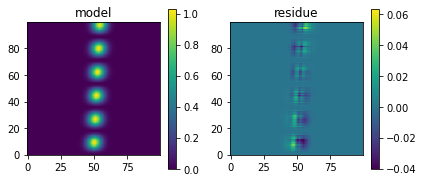

Iteration 15:


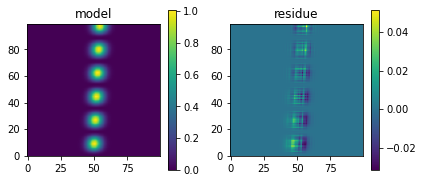

Iteration 16:


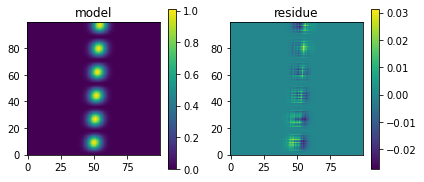

Iteration 17:


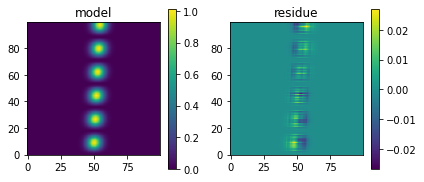

Iteration 18:


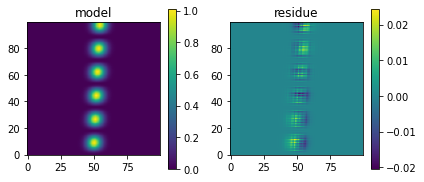

Iteration 19:


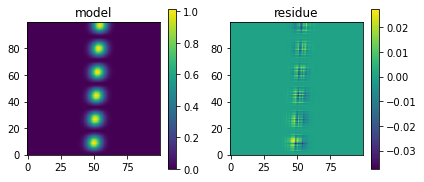

Iteration 20:


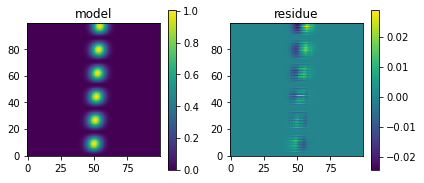

Time elapsed is 33.374797105789185. Iterations: 20.


In [130]:
# Constructing grid points
xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()


n_freq_x = int(len(data_sim[0])/2)
n_freq_y = int(len(data_sim)/2)
# n_freq_x = 15
# n_freq_y = 15
x_len = 2*n_freq_x - 1
y_len = 2*n_freq_y - 1
design_x = fourier_design(xxs_flat,n_freq_x)
design_y = fourier_design(yys_flat,n_freq_y)

initial_guess = np.zeros(y_len+x_len)
initial_guess[0] = 1
initial_guess[y_len] = 1


# initial_guess = np.ones(y_len+x_len)

# guess = minimize_pics_lstsq(data_sim, design_x, design_y, initial_guess, 20, y_len)
guess = minimize_test(data_sim, n_freq_x, n_freq_y ,initial_guess, 20, y_len, 1, 1)

In [134]:
guess[2]

-0.0482281950016831

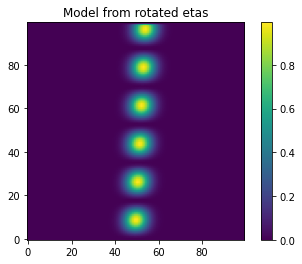

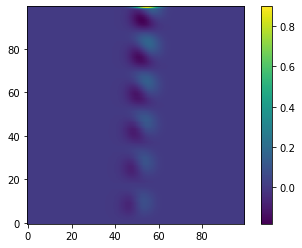

In [138]:
xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

deform = np.array([[1,guess[2]],[0,1]])

xys_stacked = np.vstack((xxs_flat,yys_flat)) 
xys_stacked = np.matmul(deform, xys_stacked)    
eta1s = xys_stacked[0]
eta2s = xys_stacked[1]

design_y1_test = fourier_design2(eta2s, n_freq_y, 1)
design_x1_test = fourier_design2(eta1s, n_freq_x, 1)

y_hat1 = np.matmul(design_y1_test,guess[0])
x_hat1 = np.matmul(design_x1_test,guess[1])

data_model_fourier1 = y_hat1*x_hat1
data_model_fourier1 = data_model_fourier1.reshape(np.shape(data_sim))
plt.title('Model from rotated etas')
plt.imshow(data_model_fourier1, origin='lower')
plt.colorbar()
plt.show()

plt.imshow(data_sim - data_model_fourier1, origin='lower')
plt.colorbar()

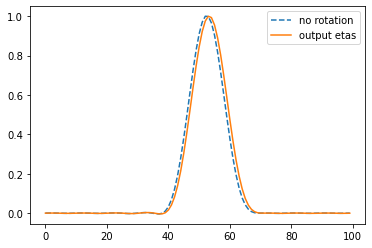

In [498]:
row = 90

plt.plot(data_model_fourier1[row]/np.max(data_model_fourier1[row]), '--', label='no rotation')
plt.plot(data_model_fourier2[row]/np.max(data_model_fourier2[row]), label='output etas')
plt.legend()
plt.show()

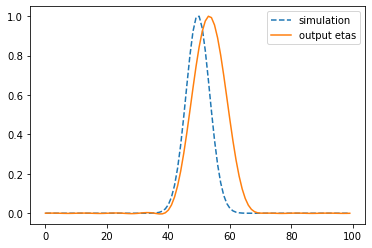

In [503]:
row = 90

plt.plot(data_sim[1]/np.max(data_sim[1]), '--', label='simulation')
plt.plot(data_model_fourier2[row]/np.max(data_model_fourier2[row]), label='output etas')
plt.legend()
plt.show()

In [482]:
data_sim

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.48558714e-38, 4.18848896e-37, 1.10325471e-35, ...,
        1.97355789e-35, 7.58488155e-37, 2.72337163e-38],
       [4.24822204e-38, 1.20510566e-36, 3.19375954e-35, ...,
        1.02199877e-34, 3.95191851e-36, 1.42765990e-37],
       ...,
       [8.25528568e-51, 4.18913256e-49, 1.98598184e-47, ...,
        6.27568189e-23, 4.34102821e-24, 2.80532684e-25],
       [5.68101089e-51, 2.90052286e-49, 1.38352221e-47, ...,
        7.82070428e-23, 5.44297357e-24, 3.53904235e-25],
       [3.66248848e-51, 1.88141938e-49, 9.02930101e-48, ...,
        9.13036076e-23, 6.39347504e-24, 4.18258891e-25]])

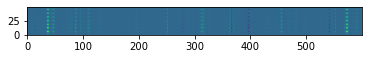

1


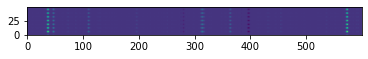

2


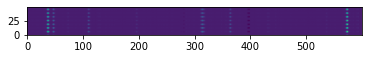

3


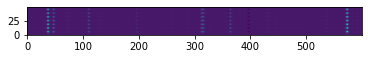

4


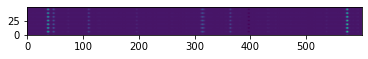

5
Time elapsed is 18.344048976898193. Iterations: 5.
(30000, 599) (30000,)


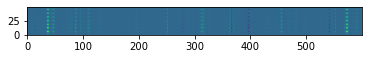

1
(30000, 599) (30000,)


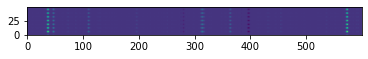

2
(30000, 599) (30000,)


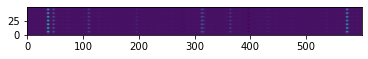

3
(30000, 599) (30000,)


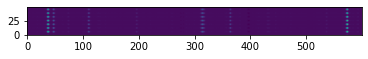

4
(30000, 599) (30000,)


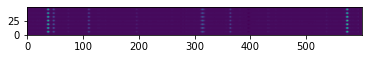

5
Time elapsed is 19.603811979293823. Iterations: 5.


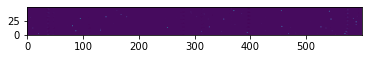

In [709]:
### Fourier ###

# Constructing grid points
xs = np.arange(len(data_actual[0]))
ys = np.arange(len(data_actual[:,0]))

xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

# Uncomment for Fourier fit
n_freq_x = int(len(data_actual[0])/2)
n_freq_y = int(len(data_actual)/2)
x_len = 2*n_freq_x - 1
y_len = 2*n_freq_y - 1
design_x = fourier_design(xxs_flat,n_freq_x)
design_y = fourier_design(yys_flat,n_freq_y)

initial_guess = np.zeros(y_len+x_len)
initial_guess[0] = 1
initial_guess[y_len] = 1

initial_guess = np.ones(x_len + y_len)


guessx1 = minimize_pics_lstsq(data_actual, design_x, design_y, initial_guess, 5, y_len)
guessx2 = minimize_test(data_actual, initial_guess, 5, y_len)

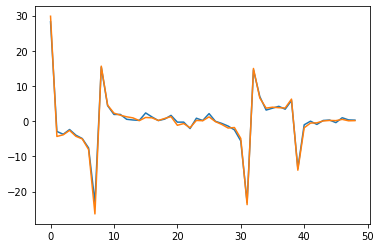

In [710]:
plt.plot(guessx1[0])
plt.plot(guessx2[0])